In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/EEG_dataset/dataset

add_stim.mat		control_stim.mat  d7.mat		    sub-01_task-1_eeg.vmrk
adhd_d5.mat		d1.mat		  first_129_of_d3.mat	    sub-05_task_eeg.eeg
adhd_stim.mat		d2.mat		  last_1840_columnsNew.mat  sub-05_task_eeg.vhdr
adhd_test_data.mat	d3.mat		  last_1840_of_d5.mat	    sub-05_task_eeg.vmrk
adhd_train_data.mat	d4.mat		  readme.txt		    sub_name_stim.mat
chan.mat		d5.mat		  sub-01_task-1_eeg.eeg     transposed_combined_data.mat
combined_adhd_data.mat	d6.mat		  sub-01_task-1_eeg.vhdr    y_stim.mat


In [ ]:
import h5py

# Load the MATLAB file using h5py
file_path = '/content/drive/MyDrive/EEG_dataset/dataset/y_stim.mat'

with h5py.File(file_path, 'r') as f:
    # Inspect the structure of the file
    print(f.keys())  # List all available datasets in the file

    # Access the dataset
    y_stim = f['y_stim'][:]  # Load the 'y_stim' dataset into a NumPy array

    # If the data is transposed, transpose it
    y_stim = y_stim.T  # Ensure correct shape if necessary

# Verify the shape of the dataset
print("y_stim shape:", y_stim.shape)


<KeysViewHDF5 ['y_stim']>
y_stim shape: (33902, 4)


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt  # For wavelet transform
from scipy.io import loadmat
import os
from sklearn.model_selection import train_test_split
import scipy.io as sio

# Load combined ADHD data
data_path = '/content/drive/MyDrive/EEG_dataset/dataset/combined_adhd_data.mat'
adhd_data = loadmat(data_path)['combined_adhd_data']

# Load ADHD stim file
stim_path = '/content/drive/MyDrive/EEG_dataset/dataset/adhd_stim.mat'
adhd_stim = loadmat(stim_path)['adhd_stim']


# Define the directory to save the split data
output_dir = '/content/drive/MyDrive/EEG_dataset/splitset/'

# Mapping trials to participants from adhd_stim
participant_to_trials = {}
for idx, participant in enumerate(adhd_stim[:, 0]):  # First column contains participant IDs
    if participant not in participant_to_trials:
        participant_to_trials[participant] = []
    participant_to_trials[participant].append(idx)  # Store indices of trials for each participant

# Split participants into training and testing sets (70% train, 30% test)
participants = list(participant_to_trials.keys())
train_participants, test_participants = train_test_split(participants, test_size=0.3, random_state=42)

# Save train and test data for each participant directly in the splitset folder
for participant in train_participants:
    # Get all trial indices for the current participant
    participant_trials = participant_to_trials[participant]

    # Extract the corresponding data for training
    train_data = adhd_data[:, :, participant_trials]
    # Save the training data for this participant directly in the splitset folder
    sio.savemat(os.path.join(output_dir, f'{int(participant)}_train.mat'), {'train_data': train_data})

for participant in test_participants:
    # Get all trial indices for the current participant
    participant_trials = participant_to_trials[participant]

    # Extract the corresponding data for testing
    test_data = adhd_data[:, :, participant_trials]

    # Save the testing data for this participant directly in the splitset folder
    sio.savemat(os.path.join(output_dir, f'{int(participant)}_test.mat'), {'test_data': test_data})

    print(f"Saved train and test data for participant {participant} in {output_dir}")



Saved train and test data for participant 28.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 41.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 27.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 44.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 25.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 38.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 13.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 20.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 5.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 26.0 in /content/drive/MyDrive/EEG_dataset/splitset/
Saved train and test data for participant 9.0 in /c

In [ ]:
import os
import scipy.io as sio
import numpy as np
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Frequency bands
delta_band = (0.5, 3.5)
theta_band = (4, 8)
alpha_band = (8, 13)
low_beta_band = (13, 20)  # Low Beta

# Function to calculate band power
def calculate_band_power(coeffs, freqs, band):
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    return np.mean(np.abs(coeffs[band_mask, :]) ** 2, axis=0)

# Placeholder for trial-level features
trial_features = []

# Define parameters for wavelet transform
wavelet = 'cmor'  # Continuous wavelet transform (complex Morlet wavelet)
sampling_rate = 256  # Sampling rate in Hz
frequencies = np.linspace(0.5, 20, 100)                                                                        #TODO
scales = pywt.scale2frequency(wavelet, frequencies) * sampling_rate

# Loop through all participants in the training set
for participant in train_participants:  # train_participants comes from the split
    # Define the file path for the current participant's training data
    train_file_path = f'/content/drive/MyDrive/EEG_dataset/splitset/{int(participant)}_train.mat'

    # Load the training data for this participant
    data = sio.loadmat(train_file_path)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trial..s)

    # Loop through trials for this participant
    for trial_idx in range(participant_data.shape[2]):
        trial_signal = participant_data[:, 18, trial_idx]  # 19th channel

        # Perform wavelet transform
        coeffs, freqs = pywt.cwt(trial_signal, scales, wavelet, sampling_period=1 / sampling_rate)

        # Compute power in each frequency band
        theta_power = np.mean(calculate_band_power(coeffs, freqs, theta_band))
        alpha_power = np.mean(calculate_band_power(coeffs, freqs, alpha_band))
        low_beta_power = np.mean(calculate_band_power(coeffs, freqs, low_beta_band))
       # beta_power = np.mean(calculate_band_power(coeffs, freqs, beta_band))  # Optional

        # Compute ratios
        theta_low_beta_ratio = theta_power / low_beta_power
        alpha_low_beta_ratio = alpha_power / low_beta_power

        # Store trial-level features
        trial_features.append([
            theta_low_beta_ratio, alpha_low_beta_ratio
        ])

# Convert trial features to a NumPy array
trial_features = np.array(trial_features)


/usr/local/lib/python3.10/dist-packages/pywt/_functions.py:141: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [ ]:
# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(trial_features)

# Save the scaler for later use
import joblib
scaler_path = "/content/drive/MyDrive/EEG_dataset/splitset/model/scaler_ratios.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /content/drive/MyDrive/EEG_dataset/splitset/model/scaler_ratios.pkl


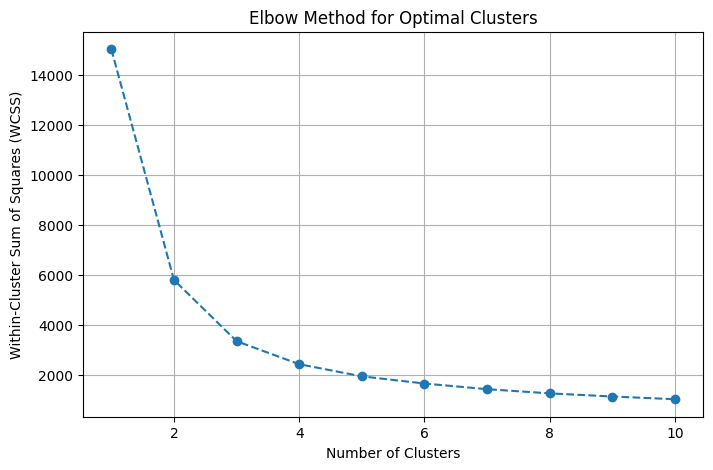

In [ ]:
# Apply the Elbow Method to find the optimal number of clusters
wcss = []
cluster_range = range(1, 11)  # Test clusters from 1 to 10

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid()
plt.show()

For n_clusters = 2, the average silhouette score is 0.511
For n_clusters = 3, the average silhouette score is 0.470
For n_clusters = 4, the average silhouette score is 0.427
For n_clusters = 5, the average silhouette score is 0.396
For n_clusters = 6, the average silhouette score is 0.365


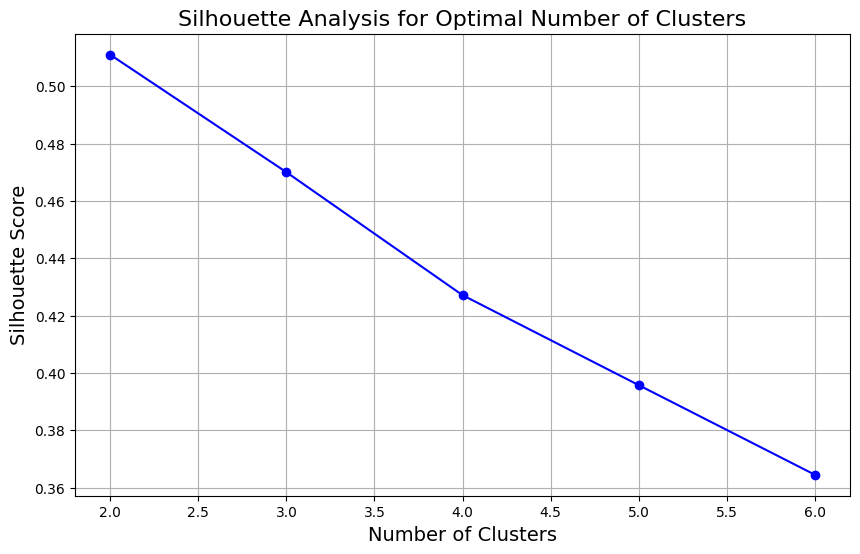

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Apply the silhouette method
range_n_clusters = [2, 3, 4, 5, 6]  # Test multiple cluster counts
silhouette_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_features)
    silhouette_avg = silhouette_score(normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title("Silhouette Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid()
plt.show()

In [ ]:
optimal_clusters = 3

# Train the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(normalized_features)

# Save the trained KMeans model for later use
kmeans_path = "/content/drive/MyDrive/EEG_dataset/splitset/model/kmeans_ratio_3clusters.pkl"
joblib.dump(kmeans, kmeans_path)
print(f"KMeans model saved to {kmeans_path}")

KMeans model saved to /content/drive/MyDrive/EEG_dataset/splitset/model/kmeans_ratio_3clusters.pkl


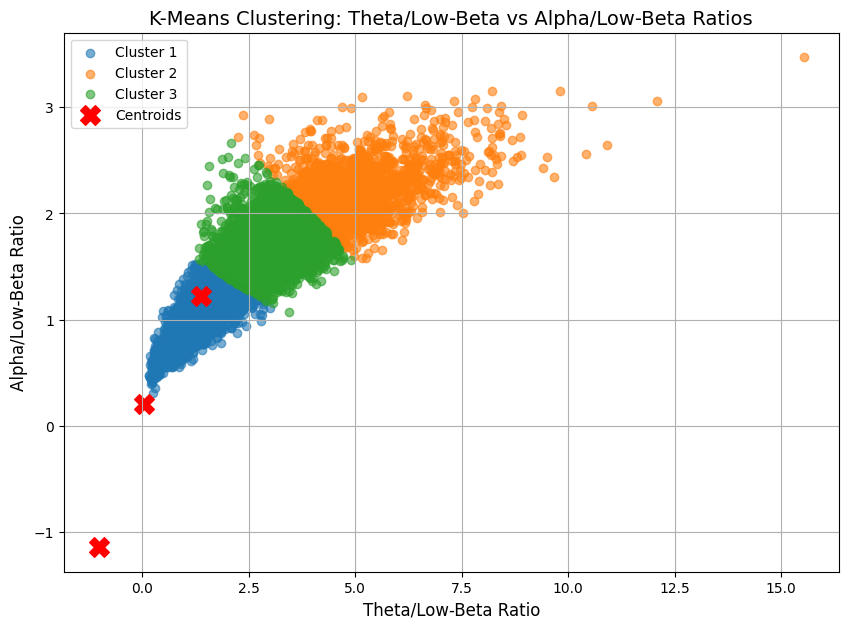

In [ ]:
import matplotlib.pyplot as plt

# Extract the cluster labels
cluster_labels = kmeans.labels_

# Extract theta/low-beta ratio and alpha/low-beta ratio for visualization
theta_low_beta_ratio = trial_features[:, 0]
alpha_low_beta_ratio = trial_features[:, 1]

# Plot the scatter plot
plt.figure(figsize=(10, 7))
for cluster in range(optimal_clusters):
    plt.scatter(
        theta_low_beta_ratio[cluster_labels == cluster],
        alpha_low_beta_ratio[cluster_labels == cluster],
        label=f'Cluster {cluster + 1}',
        alpha=0.6,
    )

# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    color='red', marker='X', s=200, label='Centroids'
)

# Add labels and legend
plt.title("K-Means Clustering: Theta/Low-Beta vs Alpha/Low-Beta Ratios", fontsize=14)
plt.xlabel("Theta/Low-Beta Ratio", fontsize=12)
plt.ylabel("Alpha/Low-Beta Ratio", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Analyze centroids
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: Theta/Low-Beta Ratio = {centroid[0]}, Alpha/Low-Beta Ratio = {centroid[1]}")

# Assign attention levels based on analysis of centroids
cluster_attention_mapping = {
    np.argmin(centroids[:, 0]): "High Attention",  # Cluster with the lowest Theta/Low-Beta
    np.argmax(centroids[:, 0]): "Low Attention",  # Cluster with the highest Theta/Low-Beta
    np.argmin(np.abs(centroids[:, 0] - np.mean(centroids[:, 0]))): "Mid Attention"  # Cluster near the mean
}

print("Cluster Attention Mapping:", cluster_attention_mapping)


Cluster 0: Theta/Low-Beta Ratio = -1.0209944248199463, Alpha/Low-Beta Ratio = -1.143015742301941
Cluster 1: Theta/Low-Beta Ratio = 1.3661699295043945, Alpha/Low-Beta Ratio = 1.2256113290786743
Cluster 2: Theta/Low-Beta Ratio = 0.04169438034296036, Alpha/Low-Beta Ratio = 0.20253877341747284
Cluster Attention Mapping: {0: 'High Attention', 1: 'Low Attention', 2: 'Mid Attention'}


In [ ]:
import joblib

# Define the mapping for cluster labels
cluster_attention_mapping = {
    0: "High Attention",
    1: "Low Attention",
    2: "Mid Attention"
}

# Save the KMeans model along with the mapping
kmeans_data = {
    "model": kmeans,
    "cluster_labels": cluster_attention_mapping
}

kmeans_path = "/content/drive/MyDrive/EEG_dataset/splitset/model/kmeans_ratio_3clusters.pkl"
joblib.dump(kmeans_data, kmeans_path)
print(f"KMeans model and cluster labels saved to {kmeans_path}")
print(type(kmeans_data))

KMeans model and cluster labels saved to /content/drive/MyDrive/EEG_dataset/splitset/model/kmeans_ratio_3clusters.pkl
<class 'dict'>
